In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
%matplotlib inline

In [2]:
from IPython.display import display

In [3]:
# load phenotypes for GWAS sample
phenostructure = pd.read_csv('/psych/genetics_data/ccarey/UKBB/ukb_files/Data_Dictionary_Showcase.csv',index_col="FieldID")
phenos = pd.read_table('/stanley/genetics/analysis/ukbb_sexdiff/family_based/ukb31063_fullsample_phesant_icd10_phenotypes_bothsexes.tsv',dtype=object,index_col="userId")
sample = pd.read_table('/psych/genetics_data/ccarey/UKBB/ukb_files/ukb_whitebritish.txt',sep=" ",index_col="IID")
phenos = phenos.loc[np.intersect1d(sample.index,phenos.index)]

In [4]:
# get shape of phenotype matrix
phenos.shape

(361144, 2772)

In [5]:
# get null-nonnull matrix
phenos_notnull=phenos.notnull()

In [6]:
# only keep one column for each cat-mult
phenos_notnull_nodupes = phenos_notnull.loc[:,~phenos_notnull.columns.str.split('_').str[0].duplicated()]

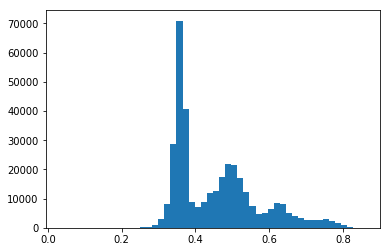

In [7]:
# plot sample-level completeness
plt.hist(phenos_notnull_nodupes.apply(np.mean,axis=1),bins=50)
plt.show()

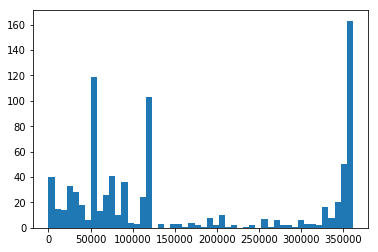

In [8]:
# plot item-level N's
plt.hist(phenos_notnull_nodupes.apply(sum,axis=0),bins=50)
plt.show()

In [9]:
# transpose df to index on items/phenos
phenos_notnull_nodupes_itemindexed = phenos_notnull_nodupes.T

In [10]:
# add path column to df
phenos_notnull_nodupes_itemindexed['path'] = phenostructure.loc[phenos_notnull_nodupes_itemindexed.index.str.split('_').str[0].values.astype(int)].Path.values

In [11]:
# create questionnaire dict
category_dict = phenos_notnull_nodupes_itemindexed.reset_index().groupby('path')['index'].apply(list).to_dict()

In [12]:
# initialize unit/questionnaire completeness df
unit_completeness = pd.DataFrame(columns=category_dict.keys(),index=phenos_notnull_nodupes.index)

In [13]:
# initialize dict of items per questionnaire
item_ns = dict()

In [14]:
# determine whether each individual attempted a questionnaire
# also create dict of items per questionnaire
for key in category_dict.keys():
    item_ns[key]=len(category_dict[key])
    unit_completeness[key] = phenos_notnull_nodupes[category_dict[key]].apply(np.any,axis=1)

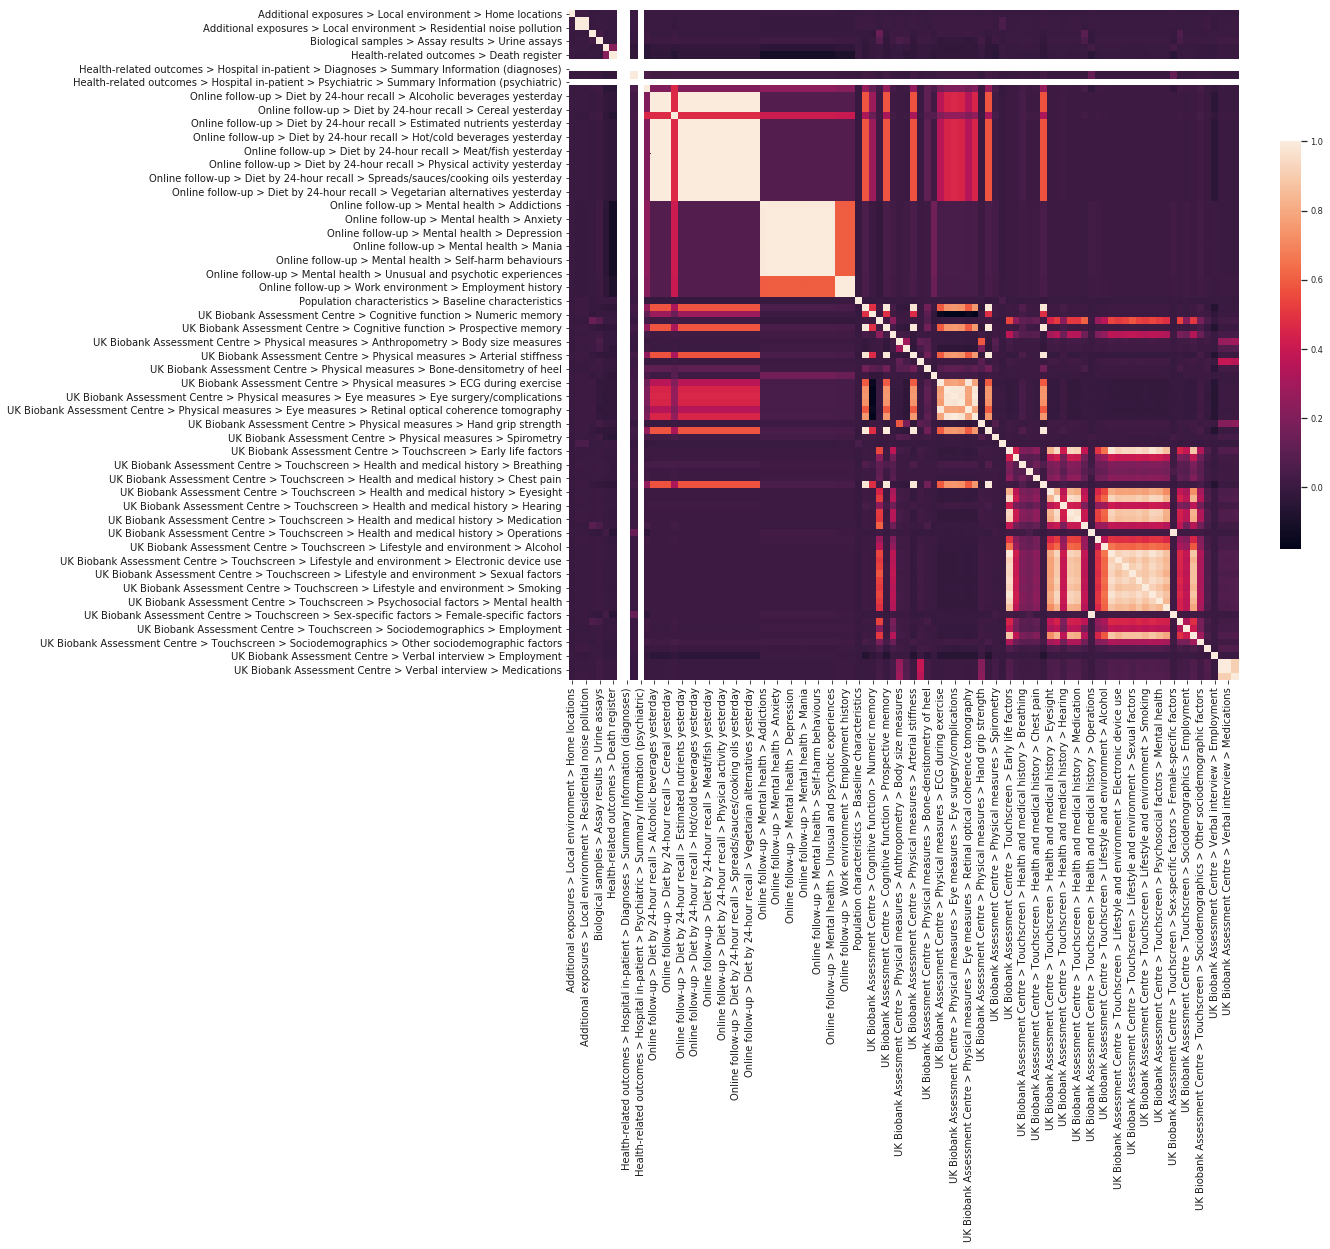

In [15]:
# visualize individual "attempt" correlations across questionnaires
f, ax = plt.subplots(figsize=(15, 15))
sns.set(font_scale=0.75)
ax = sns.heatmap(unit_completeness.corr(),square=True, cbar_kws={"shrink": 0.5})

In [16]:
# copy completeness df
unit_completeness_merge = unit_completeness.copy()

In [17]:
# create dict of lowest-level categories and their parent categories
mykeys = list(unit_completeness_merge.columns.str.rsplit(">",1).str[0].str.strip())
myvals = list(unit_completeness_merge.columns)
d = dict()
for i in range(len(mykeys)):
    if(mykeys[i] in d.keys()):
        d[mykeys[i]].append(myvals[i])
    else:
        d[mykeys[i]] = [myvals[i]]

In [18]:
# for each parent category, see if can merge some lowest-level categories with high cross-questionnaire correlations
for key in d.keys():

    if len(d[key])>1:
        tempcorr = unit_completeness[d[key]].corr()
        indices = np.where(tempcorr > 0.95)
        indices = [(tempcorr.index[x], tempcorr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
        if len(indices)>0:
            # create dict of highly correlated questionnaires
            tempd = dict()
            for x,y in indices:
                if(x in tempd.keys()):
                    tempd[x].append(y)
                elif(x in list(set(chain(*tempd.values())))):
                    pass
                else:
                    tempd[x] = [y]

            # merge highly correlated questionnaires
            counter = 1
            for tempkey in tempd.keys():
                addlist = tempd[tempkey]
                addlist.append(tempkey)
                newcol = " > ".join([key,"Group_"+str(counter)])
                print(newcol,addlist)
                unit_completeness_merge[newcol] = unit_completeness_merge.loc[:,addlist].apply(lambda x: np.any(x),axis=1)
                unit_completeness_merge.drop(addlist, inplace=True,axis=1)
                item_ns[newcol] = sum([item_ns[x] for x in addlist])
                for item in addlist:
                    item_ns.pop(item)
                counter = counter+1

Additional exposures > Local environment > Group_1 ['Additional exposures > Local environment > Residential noise pollution', 'Additional exposures > Local environment > Residential air pollution']
Online follow-up > Diet by 24-hour recall > Group_1 ['Online follow-up > Diet by 24-hour recall > Bread/pasta/rice yesterday', 'Online follow-up > Diet by 24-hour recall > Cereal yesterday', 'Online follow-up > Diet by 24-hour recall > Estimated nutrients yesterday', 'Online follow-up > Diet by 24-hour recall > Fruit/vegetables yesterday', 'Online follow-up > Diet by 24-hour recall > Hot/cold beverages yesterday', 'Online follow-up > Diet by 24-hour recall > Meal type yesterday', 'Online follow-up > Diet by 24-hour recall > Meat/fish yesterday', 'Online follow-up > Diet by 24-hour recall > Milk/eggs/cheese yesterday', 'Online follow-up > Diet by 24-hour recall > Physical activity yesterday', 'Online follow-up > Diet by 24-hour recall > Soup/snacks/pastries yesterday', 'Online follow-up > Die

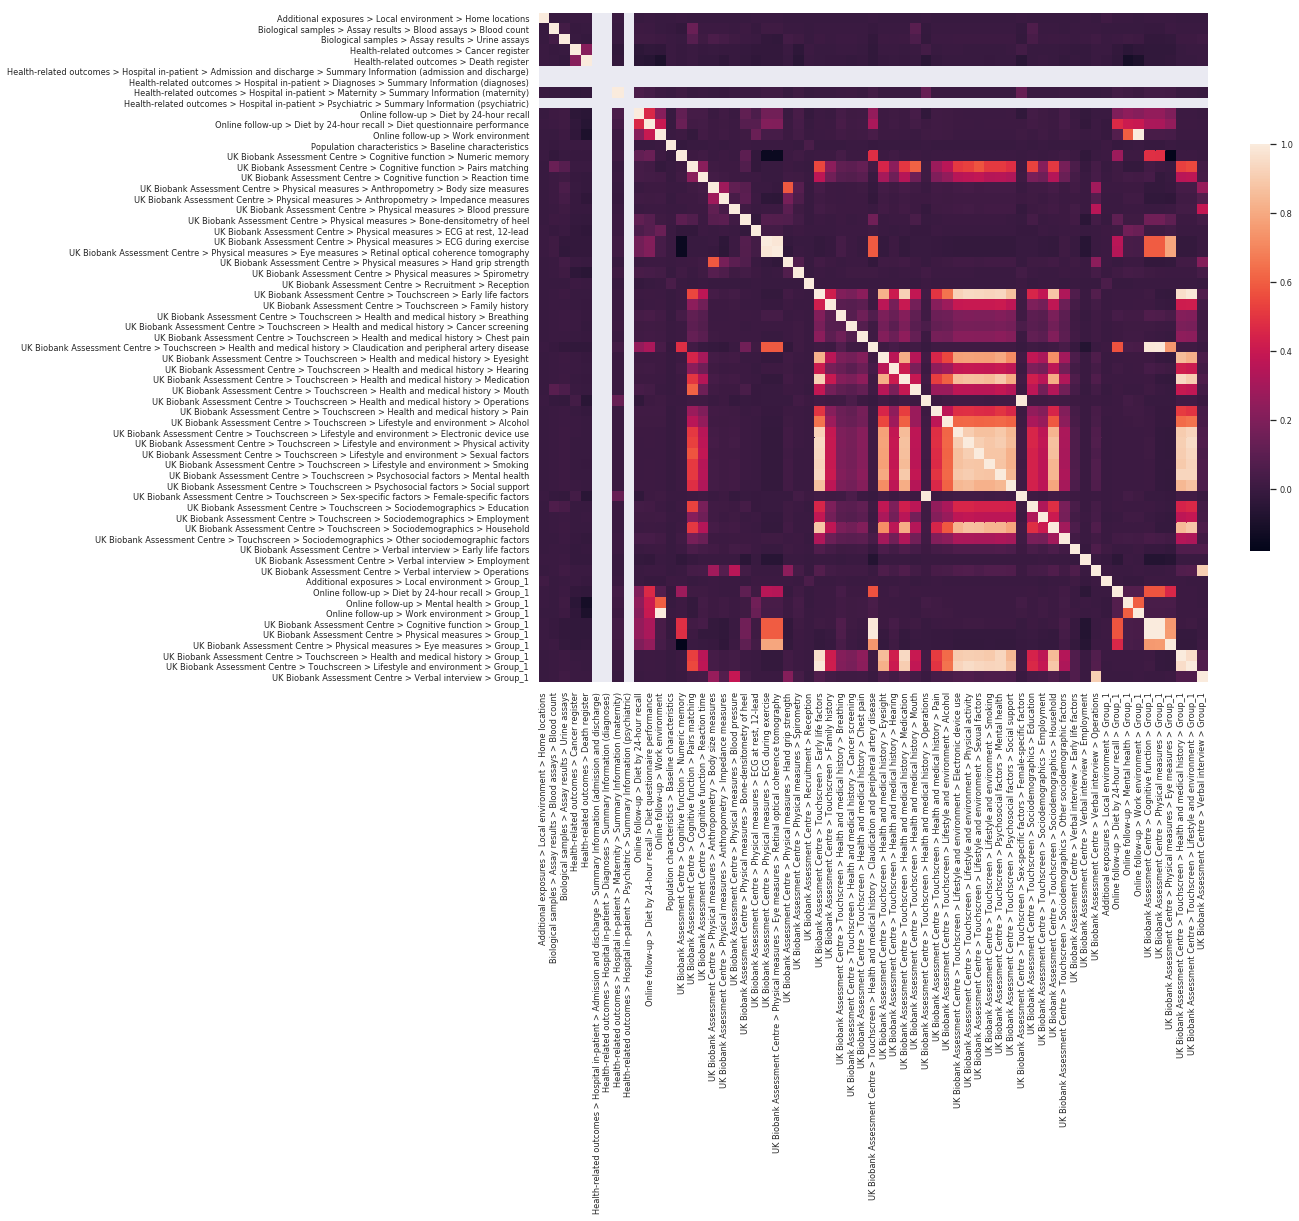

In [19]:
# visualize individual "attempt" correlations across merged questionnaires
f, ax = plt.subplots(figsize=(15, 15))
sns.set(font_scale=0.75)
ax = sns.heatmap(unit_completeness_merge.corr(),square=True, cbar_kws={"shrink": 0.5})

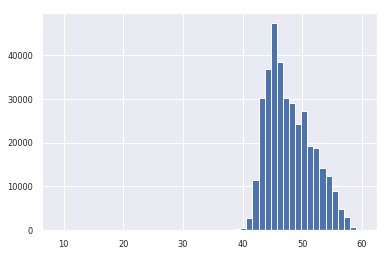

In [20]:
# plot questonnaire completeness per individual
plt.hist(unit_completeness_merge.apply(sum,axis=1),bins=50)
plt.show()

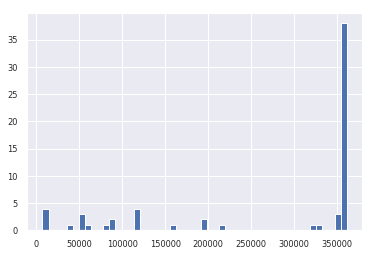

In [21]:
# plot questionnaire N's
plt.hist(unit_completeness_merge.apply(sum,axis=0),bins=50)
plt.show()

In [22]:
### SPECIFY FILTERING PARAMS
Nmin = 75000
Nmax = 250000
Nitems = 5
nmar_and_sexspecific = ['UK Biobank Assessment Centre > Touchscreen > Sex-specific factors > Female-specific factors','Health-related outcomes > Cancer register','Health-related outcomes > Death register','Health-related outcomes > Hospital in-patient > Maternity > Summary Information (maternity)']
Qmiss = 1

In [23]:
# only consider questionnaires completed by between Nmin and Nmax people
unit_completeness_merge_Nmin_Nmax = unit_completeness_merge.loc[:,(unit_completeness_merge.apply(sum,axis=0)>Nmin) & (unit_completeness_merge.apply(sum,axis=0)<Nmax)]

In [24]:
# remove questionnaires consisting of less than Nitems items
unit_completeness_merge_Nmin_Nmax_Nitems = unit_completeness_merge_Nmin_Nmax.loc[:,[item_ns[x] >= Nitems for x in unit_completeness_merge_Nmin_Nmax.columns.values]]

In [25]:
# drop sex-specific and MNAR questionnaires
unit_completeness_merge_Nmin_Nmax_Nitems_dropped = unit_completeness_merge_Nmin_Nmax_Nitems.drop(np.intersect1d(nmar_and_sexspecific,unit_completeness_merge_Nmin_Nmax_Nitems.columns.values),axis=1)

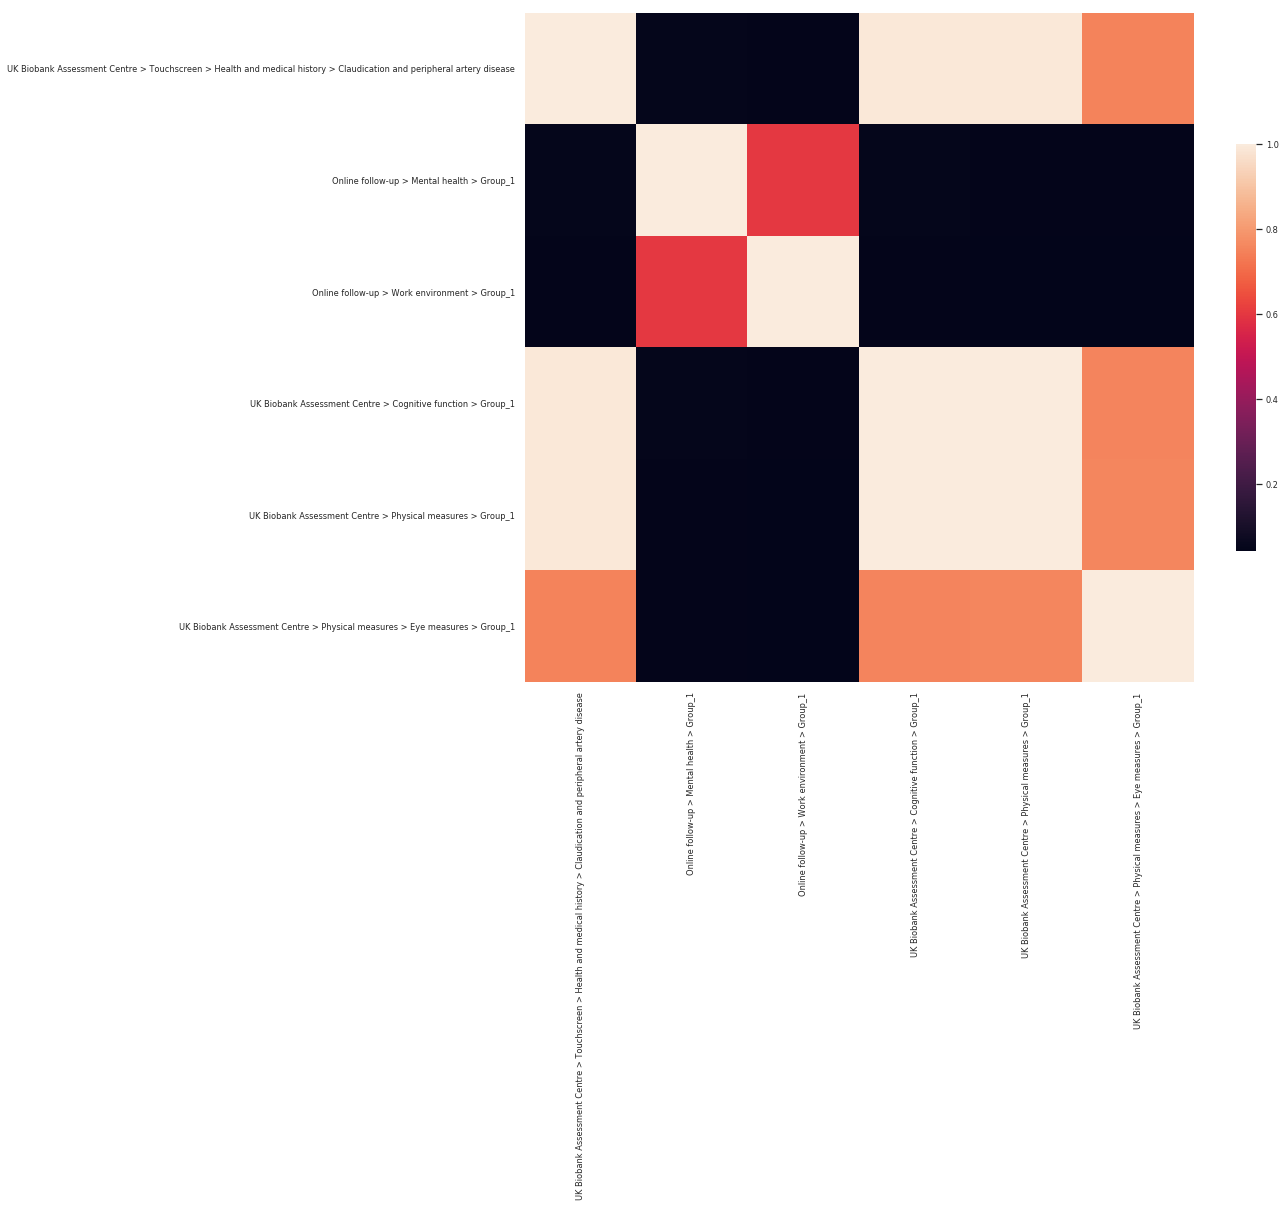

In [26]:
# visualize individual "attempt" correlations across merged questionnaires
f, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(unit_completeness_merge_Nmin_Nmax_Nitems_dropped.corr(),square=True, cbar_kws={"shrink": 0.5})

In [27]:
# get questionnaire-level completeness patterns and their frequencies
missingness_patterns = unit_completeness_merge_Nmin_Nmax_Nitems_dropped.groupby(list(unit_completeness_merge_Nmin_Nmax_Nitems_dropped.columns), as_index=False).size().reset_index().rename(columns={0:"N"})

In [28]:
# calculate number of questionnaires included in each pattern
missingness_patterns["n_questionnaires"] = missingness_patterns.iloc[:,:-1].apply(sum,axis=1)

In [29]:
# sort completeness pattern dataframe by number of questionnaires, then N per pattern
missingness_patterns_toplot = missingness_patterns.sort_values(["n_questionnaires","N"],ascending=[False,False])

In [30]:
# define x-labels to be n_questionnaires plus N individuals
xlabs = missingness_patterns_toplot.apply(lambda x: "_".join([str(x.n_questionnaires),str(x.N)]),axis=1).tolist()

In [31]:
# define y-labels to be the category/path, plus N individuals, plus n_items
ylabs = [", N=".join([x,y,z]) for x,y,z in zip(unit_completeness_merge_Nmin_Nmax_Nitems_dropped.columns.values, unit_completeness_merge_Nmin_Nmax_Nitems_dropped.apply(sum,axis=0).astype(str).values,[str(item_ns[x]) for x in unit_completeness_merge_Nmin_Nmax_Nitems_dropped.columns.values])]

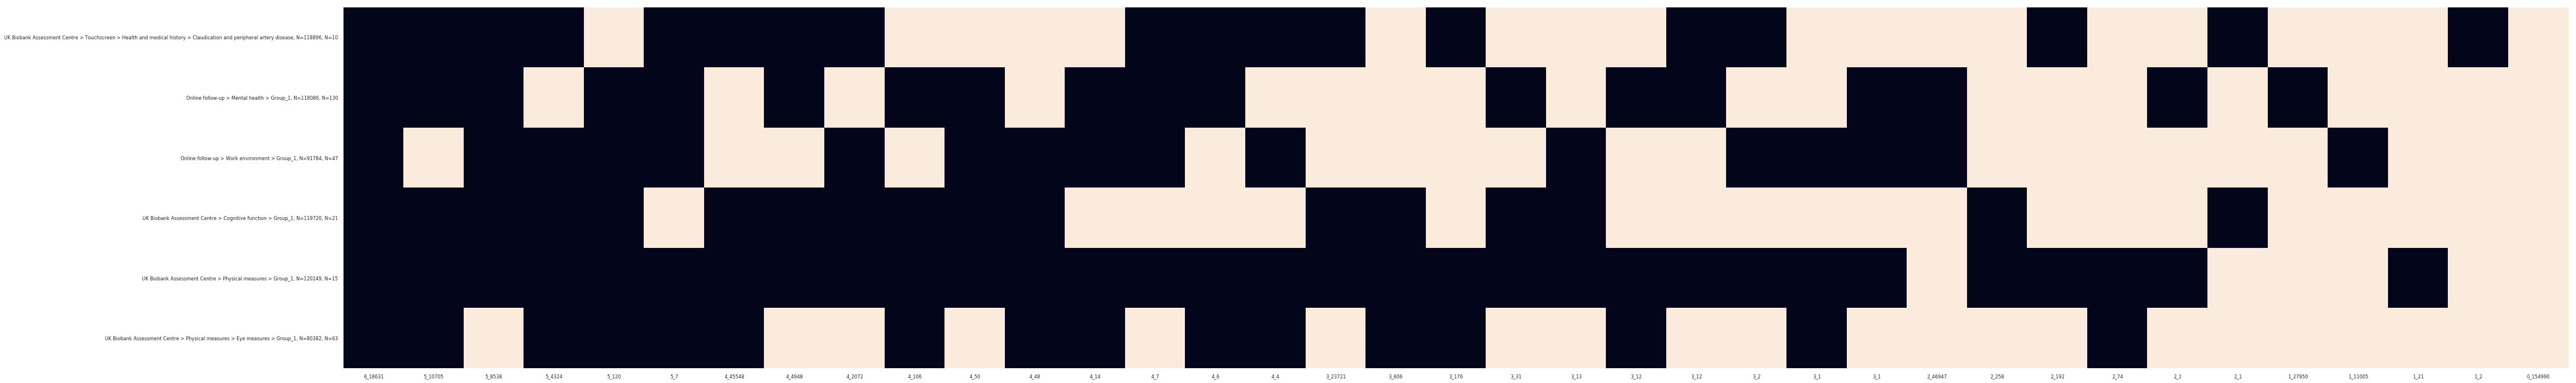

In [32]:
# plot completeness patterns
f, ax = plt.subplots(figsize=(70, 70))
sns.heatmap(~missingness_patterns_toplot.iloc[:,:-2].astype(int).T,square=True,cbar=False, xticklabels=xlabs,yticklabels=ylabs)

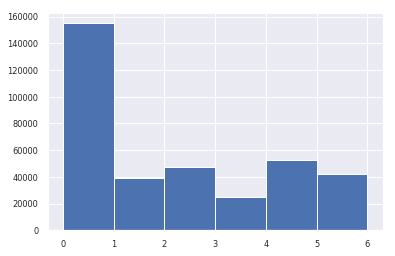

In [33]:
# plot questonnaire completeness per individual
qhist = plt.hist(unit_completeness_merge_Nmin_Nmax_Nitems_dropped.apply(sum,axis=1),bins=missingness_patterns_toplot.iloc[:,:-2].shape[1])
plt.show()

In [34]:
qhist[0]

array([154990.,  38978.,  47473.,  24575.,  52803.,  42325.])

In [35]:
qhist[0][len(qhist[0])-Qmiss:]

array([42325.])

In [36]:
# get list of individuals missing Qmiss questionnaires or less
inds_Qmiss = unit_completeness_merge_Nmin_Nmax_Nitems_dropped[unit_completeness_merge_Nmin_Nmax_Nitems_dropped.apply(sum,axis=1)>=(len(qhist[0])-Qmiss)].index.values

In [166]:
# subset original phenotype file to "core" individuals
phenos_Qmiss = phenos.loc[inds_Qmiss]

In [167]:
phenos_Qmiss.shape

(42325, 2772)

In [168]:
# get null-nonnull matrix
phenos_Qmiss_notnull=phenos_Qmiss.notnull()

In [169]:
# remove items that are mnar or sex-specific
remove_cats = [category_dict[x] for x in nmar_and_sexspecific]
flat_remove_cats = [val for sublist in remove_cats for val in sublist]
phenos_Qmiss_notnull_removed = phenos_Qmiss_notnull.drop(flat_remove_cats,axis=1)

In [170]:
# load phenosummary file
phenosummary = pd.read_table('/stanley/genetics/analysis/ukbb_sexdiff/family_based/ukb31063_gwas_phesant_icd10_phenotypes_summary.tsv',dtype=object)

In [171]:
# subset to the both-sexes row of all phenotypes
phenosummary_bothsexes = phenosummary[phenosummary.sex=="both"]

In [172]:
phenos_Qmiss_notnull_removed_bothsexes = phenos_Qmiss_notnull_removed.loc[:,np.intersect1d(phenos_Qmiss_notnull_removed.columns.values,phenosummary_bothsexes.id.values)]

In [173]:
2772-phenos_Qmiss_notnull_removed_bothsexes.shape[1]

113

In [174]:
# transpose df to index on items/phenos
phenos_Qmiss_notnull_removed_bothsexes_itemindexed = phenos_Qmiss_notnull_removed_bothsexes.T

In [175]:
# add Ns to items
phenos_Qmiss_notnull_removed_bothsexes_itemindexed['N']=phenos_Qmiss_notnull_removed_bothsexes_itemindexed.apply(sum,axis=1)

In [176]:
# add path column to df
phenos_Qmiss_notnull_removed_bothsexes_itemindexed['name'] = phenostructure.loc[phenos_Qmiss_notnull_removed_bothsexes_itemindexed.index.str.split('_').str[0].values.astype(int)].Field.values

In [177]:
# remove all phenotypes N<30k
phenos_Qmiss_notnull_removed_bothsexes_itemindexed_minN = phenos_Qmiss_notnull_removed_bothsexes_itemindexed[phenos_Qmiss_notnull_removed_bothsexes_itemindexed.N>=30000]

In [183]:
phenos_Qmiss_notnull_removed_bothsexes_itemindexed.shape

(2659, 42327)

In [184]:
phenos_Qmiss_notnull_removed_bothsexes_itemindexed_minN.shape

(2120, 42327)

In [178]:
phenos_inds_items = phenos_Qmiss_notnull_removed_bothsexes_itemindexed_minN.copy().T

In [179]:
phenos_inds_items = phenos_inds_items.drop(["N","name"],axis=0)

In [180]:
# subset to binary phenotypes
phenosummary_bothsexes_binary = phenosummary_bothsexes[~pd.isnull(phenosummary_bothsexes.GWAS_n_cases)]

In [181]:
# calculate Neff 
phenosummary_bothsexes_binary['Neff'] = phenosummary_bothsexes_binary.apply(lambda x: float(4)/((1.0/int(x.GWAS_n_cases))+(1.0/int(x.GWAS_n_controls))),axis=1)

/broad/software/free/Linux/redhat_7_x86_64/pkgs/anaconda3_5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [182]:
# calculate GWAS prevalence 
phenosummary_bothsexes_binary['prevalence'] = phenosummary_bothsexes_binary.apply(lambda x: float(x.GWAS_n_cases)/float(x.GWAS_n_nonmiss),axis=1)

/broad/software/free/Linux/redhat_7_x86_64/pkgs/anaconda3_5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [219]:
phenosummary_bothsexes_binary[phenosummary_bothsexes_binary.id=="1767"]

,id,name,sex,source,variable_type,GWAS_n_nonmiss,GWAS_n_miss,GWAS_n_cases,GWAS_n_controls,PHESANT_transformation,notes,Neff,prevalence
627,1767,Adopted as a child,both,phesant,CAT-UNORDERED,360450,744,5158,355292,1767_0|| CAT-SINGLE || Inc(>=10): 0(355292) ||...,"ACE touchscreen question ""Were you adopted as ...",20336.758341,0.01431


In [220]:
1-0.01431

0.98569

In [185]:
# subset to phenotypes with prevalence >=1% in GWAS sample
phenosummary_underPrev = phenosummary_bothsexes_binary[(phenosummary_bothsexes_binary.prevalence<0.01) | (phenosummary_bothsexes_binary.prevalence>0.99)].id.values
phenos_inds_items_bothsexes_prev = phenos_inds_items.drop(np.intersect1d(phenos_inds_items.columns.values,phenosummary_underPrev),axis=1)

In [186]:
phenos_inds_items_bothsexes_prev.shape

(42325, 979)

In [209]:
def sampprev(x):
    #print(x.name)
    if x.name in phenosummary_bothsexes_binary.id.values:
        if x.sum()==42325:
            return True
        else:
            #print((float(x.value_counts()[1])/x.value_counts().sum()))
            print(x.value_counts())
            print((float(x.value_counts()[1])/x.value_counts().sum()))
            return ((float(x.value_counts()[1])/x.value_counts().sum()))<0.99
    else:
        return True

In [215]:
phenos_inds_items_bothsexes_prev.apply(lambda x: sampprev(x)).sum()

730

In [211]:
# subset to phenotypes with prevalence >=1% in core sample

def sampprev(x):
    #print(x.name)
    if x.name in phenosummary_bothsexes_binary.id.values:
        if x.sum()==42325:
            return True
        else:
            return ((float(x.value_counts()[1])/x.value_counts().sum()))<0.99
    else:
        return True
    
phenos_inds_items_bothsexes_prev_sampprev = phenos_inds_items_bothsexes_prev.loc[:,phenos_inds_items_bothsexes_prev.apply(lambda x: sampprev(x))]

In [212]:
new = phenos_inds_items_bothsexes_prev_sampprev.columns

In [213]:
len(new)

730

In [214]:
phenos_inds_items_bothsexes_prev.shape

(42325, 979)

In [141]:
# subset original phenotype file to "core" individuals
phenos_Qmiss = phenos.loc[inds_Qmiss]

In [142]:
# get null-nonnull matrix
phenos_Qmiss_notnull=phenos_Qmiss.notnull()

In [143]:
# remove items that are mnar or sex-specific
remove_cats = [category_dict[x] for x in nmar_and_sexspecific]
flat_remove_cats = [val for sublist in remove_cats for val in sublist]
phenos_Qmiss_notnull_removed = phenos_Qmiss_notnull.drop(flat_remove_cats,axis=1)

In [144]:
# only keep one column for each cat-mult
phenos_Qmiss_notnull_removed_nodupes = phenos_Qmiss_notnull_removed.loc[:,~phenos_Qmiss_notnull_removed.columns.str.split('_').str[0].duplicated()]

In [145]:
# transpose df to index on items/phenos
phenos_Qmiss_notnull_removed_nodupes_itemindexed = phenos_Qmiss_notnull_removed_nodupes.T

In [146]:
# add Ns to items
phenos_Qmiss_notnull_removed_nodupes_itemindexed['N']=phenos_Qmiss_notnull_removed_nodupes_itemindexed.apply(sum,axis=1)

In [147]:
# add path column to df
phenos_Qmiss_notnull_removed_nodupes_itemindexed['name'] = phenostructure.loc[phenos_Qmiss_notnull_removed_nodupes_itemindexed.index.str.split('_').str[0].values.astype(int)].Field.values

In [148]:
# remove all phenotypes N<30k
phenos_Qmiss_notnull_removed_nodupes_itemindexed_minN = phenos_Qmiss_notnull_removed_nodupes_itemindexed[phenos_Qmiss_notnull_removed_nodupes_itemindexed.N>=30000]

In [149]:
# reintroduce all cat-mult dummies
phenos_inds_items = phenos.loc[inds_Qmiss, list(np.apply_along_axis(np.any,0,np.array([phenos.columns.str.split("_").str[0]==(x.split("_")[0]) for x in phenos_Qmiss_notnull_removed_nodupes_itemindexed_minN.index.values])))]

In [151]:
# load phenosummary file
phenosummary = pd.read_table('/stanley/genetics/analysis/ukbb_sexdiff/family_based/ukb31063_gwas_phesant_icd10_phenotypes_summary.tsv',dtype=object)

In [152]:
# subset to the both-sexes row of all phenotypes
phenosummary_bothsexes = phenosummary[phenosummary.sex=="both"]

In [153]:
# subset to binary phenotypes
phenosummary_bothsexes_binary = phenosummary_bothsexes[~pd.isnull(phenosummary_bothsexes.GWAS_n_cases)]

In [154]:
# calculate Neff 
phenosummary_bothsexes_binary['Neff'] = phenosummary_bothsexes_binary.apply(lambda x: float(4)/((1.0/int(x.GWAS_n_cases))+(1.0/int(x.GWAS_n_controls))),axis=1)

/broad/software/free/Linux/redhat_7_x86_64/pkgs/anaconda3_5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [155]:
# calculate GWAS prevalence 
phenosummary_bothsexes_binary['prevalence'] = phenosummary_bothsexes_binary.apply(lambda x: float(x.GWAS_n_cases)/float(x.GWAS_n_nonmiss),axis=1)

/broad/software/free/Linux/redhat_7_x86_64/pkgs/anaconda3_5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [156]:
# "manually" remove phenotypes not applicable to both sexes
phenos_inds_items_bothsexes = phenos_inds_items.loc[:,np.intersect1d(phenos_inds_items.columns.values,phenosummary_bothsexes.id.values)]

In [157]:
phenos_inds_items_bothsexes.shape

(42325, 2104)

In [158]:
# subset to phenotypes with prevalence >=1% in GWAS sample
phenosummary_underPrev = phenosummary_bothsexes_binary[(phenosummary_bothsexes_binary.prevalence<0.01) | (phenosummary_bothsexes_binary.prevalence>0.99)].id.values
phenos_inds_items_bothsexes_prev = phenos_inds_items_bothsexes.drop(np.intersect1d(phenos_inds_items_bothsexes.columns.values,phenosummary_underPrev),axis=1)

In [159]:
phenos_inds_items_bothsexes_prev.shape

(42325, 979)

In [160]:
# subset to phenotypes with prevalence >=1% in core sample

def sampprev(x):
    if x.name in phenosummary_bothsexes_binary.id.values:
        return ((float(x.value_counts()[0])/x.value_counts().sum()))<0.99
    else:
        return True
    
phenos_inds_items_bothsexes_prev_sampprev = phenos_inds_items_bothsexes_prev.loc[:,phenos_inds_items_bothsexes_prev.apply(lambda x: sampprev(x))]

In [162]:
old = phenos_inds_items_bothsexes_prev_sampprev.columns

In [165]:
np.setdiff1d(new,old)

array(['1747_6', '20002_1081', '20002_1113', '20002_1294', '20002_1458',
       '20002_1464', '20003_1140864992', '20003_1140876592',
       '20003_1140879540', '20003_1140881856', '20003_1140884516',
       '20003_1140888266', '20003_1140909726', '20003_1140911732',
       '20003_1141176832', '20118_11', '20118_12', '22617_2112',
       '22617_7112', '3089', '41202_D64', '41202_J18', '41202_K59',
       '41202_L03', '41202_M19', '41202_N32', '41202_R06', '41202_R51',
       '41202_R55', '41202_T84', '41202_Z03', '41202_Z08', '41202_Z46',
       '41248_1001', '4849_0', '4924', '5183', '6148_1', '6148_3',
       '6150_3', '6159_8'], dtype=object)

In [98]:
remove_dependencies = phenos_inds_items_bothsexes_prev_sampprev.copy()

In [99]:
while True:
    corrmat = remove_dependencies.astype(float).corr()
    display(corrmat.shape)
    
    indices = np.where(np.isnan(corrmat))
    
    if len(indices[0])==0:
        break
    
    indices = [(corrmat.index[x], corrmat.columns[y]) for x, y in zip(*indices)]
               #if x != y and x < y]
    tempd = dict()
    for y,x in indices:
        if(y in tempd.keys()):
            tempd[y].append(x)
        #elif(y in list(set(chain(*tempd.values())))):
        #    pass
        else:
            tempd[y] = [x]
            
    keypairs = pd.DataFrame(columns=['values','len','prev','sampprev',"n_case",'std'],index=tempd.keys())
    
    for key in tempd.keys():
        keypairs.loc[key,'values'] = tempd[key]
        keypairs.loc[key,'len'] = len(tempd[key])
        try:
            keypairs.loc[key,'prev'] = phenosummary_bothsexes_binary.set_index('id').loc[str(key)].prevalence
            keypairs.loc[key,'sampprev'] = float(remove_dependencies[key].value_counts()[0])/remove_dependencies[key].value_counts().sum()
            keypairs.loc[key,'n_case'] = remove_dependencies[key].value_counts()[1]
        except:
            keypairs.loc[key,'std'] = np.std(remove_dependencies[key].astype(float))
    
    display(keypairs.sort_values(['len','sampprev','std'],ascending=[False,False,True]))
    
    firstix = keypairs.sort_values(['len','sampprev','std'],ascending=[False,False,True]).index[0]
    
    remove_dependencies.drop(firstix,axis=1, inplace=True)

(938, 938)

,values,len,prev,sampprev,n_case,std
1767,"[1777, 1787, 1797, 1835, 1873, 1883, 20107_1, ...",44,0.0143099,0.987987,508,NaN
20117_0,"[1568, 1578, 1588, 1598, 1608, 1628, 5364]",7,0.0311677,0.976367,1000,NaN
20117_1,"[1568, 1578, 1588, 1598, 1608, 1628, 5364]",7,0.0348298,0.972042,1183,NaN
20117_2,"[1568, 1578, 1588, 1598, 1608, 1628, 5364]",7,0.934003,0.948408,2183,NaN
2129,"[2139, 2149, 2159]",3,0.917978,0.955015,1904,NaN
5364,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.154505
1608,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.475656
1628,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.726418
1568,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.811122
1588,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.831882


(937, 937)

,values,len,prev,sampprev,n_case,std
20117_0,"[1568, 1578, 1588, 1598, 1608, 1628, 5364]",7,0.0311677,0.976367,1000,NaN
20117_1,"[1568, 1578, 1588, 1598, 1608, 1628, 5364]",7,0.0348298,0.972042,1183,NaN
20117_2,"[1568, 1578, 1588, 1598, 1608, 1628, 5364]",7,0.934003,0.948408,2183,NaN
2129,"[2139, 2149, 2159]",3,0.917978,0.955015,1904,NaN
5364,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.154505
1608,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.475656
1628,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.726418
1568,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.811122
1588,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.831882
1598,"[20117_0, 20117_1, 20117_2]",3,NaN,NaN,NaN,0.847237


(936, 936)

,values,len,prev,sampprev,n_case,std
20117_1,"[1568, 1578, 1588, 1598, 1608, 1628, 5364]",7,0.0348298,0.972042,1183,NaN
20117_2,"[1568, 1578, 1588, 1598, 1608, 1628, 5364]",7,0.934003,0.948408,2183,NaN
2129,"[2139, 2149, 2159]",3,0.917978,0.955015,1904,NaN
6164_100,"[971, 981]",2,0.05916,0.963381,1548,NaN
6164_1,"[971, 981]",2,0.719735,0.758309,10217,NaN
5364,"[20117_1, 20117_2]",2,NaN,NaN,NaN,0.154505
1608,"[20117_1, 20117_2]",2,NaN,NaN,NaN,0.475656
1628,"[20117_1, 20117_2]",2,NaN,NaN,NaN,0.726418
1568,"[20117_1, 20117_2]",2,NaN,NaN,NaN,0.811122
1588,"[20117_1, 20117_2]",2,NaN,NaN,NaN,0.831882


(935, 935)

,values,len,prev,sampprev,n_case,std
20117_2,"[1568, 1578, 1588, 1598, 1608, 1628, 5364]",7,0.934003,0.948408,2183,NaN
2129,"[2139, 2149, 2159]",3,0.917978,0.955015,1904,NaN
6164_100,"[971, 981]",2,0.05916,0.963381,1548,NaN
6164_1,"[971, 981]",2,0.719735,0.758309,10217,NaN
971,"[6164_1, 6164_100]",2,NaN,NaN,NaN,1.44406
981,"[6164_1, 6164_100]",2,NaN,NaN,NaN,1.50066
6144_2,[1408],1,0.0220164,0.982239,751,NaN
2159,[2129],1,0.0339882,0.955031,1790,NaN
2207,[2217],1,0.892122,0.907004,3934,NaN
1797,[1807],1,0.231067,0.753144,10226,NaN


(934, 934)

,values,len,prev,sampprev,n_case,std
2129,"[2139, 2149, 2159]",3,0.917978,0.955015,1904,NaN
6164_100,"[971, 981]",2,0.05916,0.963381,1548,NaN
6164_1,"[971, 981]",2,0.719735,0.758309,10217,NaN
971,"[6164_1, 6164_100]",2,NaN,NaN,NaN,1.44406
981,"[6164_1, 6164_100]",2,NaN,NaN,NaN,1.50066
6144_2,[1408],1,0.0220164,0.982239,751,NaN
2159,[2129],1,0.0339882,0.955031,1790,NaN
2207,[2217],1,0.892122,0.907004,3934,NaN
1797,[1807],1,0.231067,0.753144,10226,NaN
5012,[20128],1,0.648497,0.721085,8491,NaN


(933, 933)

,values,len,prev,sampprev,n_case,std
6164_100,"[971, 981]",2,0.05916,0.963381,1548,NaN
6164_1,"[971, 981]",2,0.719735,0.758309,10217,NaN
971,"[6164_1, 6164_100]",2,NaN,NaN,NaN,1.44406
981,"[6164_1, 6164_100]",2,NaN,NaN,NaN,1.50066
6144_2,[1408],1,0.0220164,0.982239,751,NaN
2207,[2217],1,0.892122,0.907004,3934,NaN
1797,[1807],1,0.231067,0.753144,10226,NaN
5012,[20128],1,0.648497,0.721085,8491,NaN
4269,[20019],1,NaN,NaN,NaN,0.198872
4276,[20021],1,NaN,NaN,NaN,0.201917


(932, 932)

,values,len,prev,sampprev,n_case,std
6164_1,"[971, 981]",2,0.719735,0.758309,10217,NaN
6144_2,[1408],1,0.0220164,0.982239,751,NaN
2207,[2217],1,0.892122,0.907004,3934,NaN
1797,[1807],1,0.231067,0.753144,10226,NaN
5012,[20128],1,0.648497,0.721085,8491,NaN
4269,[20019],1,NaN,NaN,NaN,0.198872
4276,[20021],1,NaN,NaN,NaN,0.201917
20128,[5012],1,NaN,NaN,NaN,0.820502
1408,[6144_2],1,NaN,NaN,NaN,1.07564
971,[6164_1],1,NaN,NaN,NaN,1.44406


(931, 931)

,values,len,prev,sampprev,n_case,std
6144_2,[1408],1,0.0220164,0.982239,751,NaN
2207,[2217],1,0.892122,0.907004,3934,NaN
1797,[1807],1,0.231067,0.753144,10226,NaN
5012,[20128],1,0.648497,0.721085,8491,NaN
4269,[20019],1,NaN,NaN,NaN,0.198872
4276,[20021],1,NaN,NaN,NaN,0.201917
20128,[5012],1,NaN,NaN,NaN,0.820502
1408,[6144_2],1,NaN,NaN,NaN,1.07564
20019,[4269],1,NaN,NaN,NaN,1.76389
20021,[4276],1,NaN,NaN,NaN,1.77545


(930, 930)

,values,len,prev,sampprev,n_case,std
2207,[2217],1,0.892122,0.907004,3934,NaN
1797,[1807],1,0.231067,0.753144,10226,NaN
5012,[20128],1,0.648497,0.721085,8491,NaN
4269,[20019],1,NaN,NaN,NaN,0.198872
4276,[20021],1,NaN,NaN,NaN,0.201917
20128,[5012],1,NaN,NaN,NaN,0.820502
20019,[4269],1,NaN,NaN,NaN,1.76389
20021,[4276],1,NaN,NaN,NaN,1.77545
1807,[1797],1,NaN,NaN,NaN,12.8031
2217,[2207],1,NaN,NaN,NaN,16.878


(929, 929)

,values,len,prev,sampprev,n_case,std
1797,[1807],1,0.231067,0.753144,10226,NaN
5012,[20128],1,0.648497,0.721085,8491,NaN
4269,[20019],1,NaN,NaN,NaN,0.198872
4276,[20021],1,NaN,NaN,NaN,0.201917
20128,[5012],1,NaN,NaN,NaN,0.820502
20019,[4269],1,NaN,NaN,NaN,1.76389
20021,[4276],1,NaN,NaN,NaN,1.77545
1807,[1797],1,NaN,NaN,NaN,12.8031


(928, 928)

,values,len,prev,sampprev,n_case,std
5012,[20128],1,0.648497,0.721085,8491,NaN
4269,[20019],1,NaN,NaN,NaN,0.198872
4276,[20021],1,NaN,NaN,NaN,0.201917
20128,[5012],1,NaN,NaN,NaN,0.820502
20019,[4269],1,NaN,NaN,NaN,1.76389
20021,[4276],1,NaN,NaN,NaN,1.77545


(927, 927)

,values,len,prev,sampprev,n_case,std
4269,[20019],1,NaN,NaN,NaN,0.198872
4276,[20021],1,NaN,NaN,NaN,0.201917
20019,[4269],1,NaN,NaN,NaN,1.76389
20021,[4276],1,NaN,NaN,NaN,1.77545


(926, 926)

,values,len,prev,sampprev,n_case,std
4276,[20021],1,NaN,NaN,NaN,0.201917
20021,[4276],1,NaN,NaN,NaN,1.77545


(925, 925)

In [108]:
# get null-nonnull matrix
remove_dependencies_notnull=remove_dependencies.notnull()

In [121]:
np.mean(remove_dependencies_notnull.apply(np.mean,axis=0))

0.9066990118293143

In [109]:
# only keep one column for each cat-mult
remove_dependencies_notnull_nodupes = remove_dependencies_notnull.loc[:,~remove_dependencies_notnull.columns.str.split('_').str[0].duplicated()]

/broad/software/free/Linux/redhat_6_x86_64/pkgs/anaconda3_4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


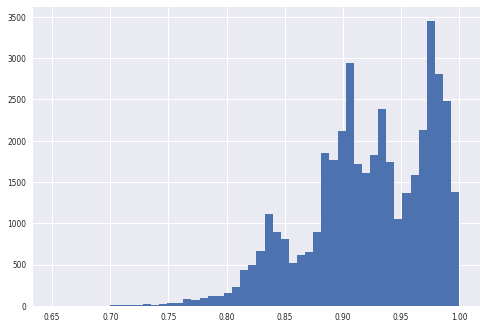

In [110]:
# plot sample-level completeness
plt.hist(remove_dependencies_notnull_nodupes.apply(np.mean,axis=1),bins=50)
plt.show()

/broad/software/free/Linux/redhat_6_x86_64/pkgs/anaconda3_4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


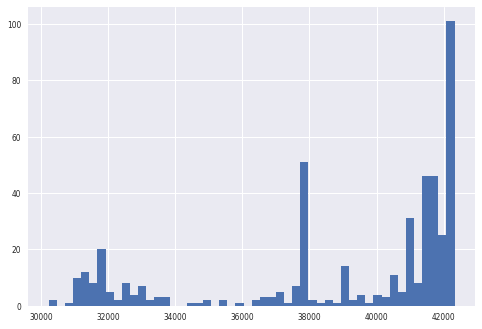

In [111]:
# plot item-level N's
plt.hist(remove_dependencies_notnull_nodupes.apply(sum,axis=0),bins=50)
plt.show()

In [116]:
np.linalg.matrix_rank(np.asmatrix(remove_dependencies.astype(float).corr()))

925

In [125]:
remove_dependencies

,102,1031,1050,1060,1070,1080,1100,110001,1110,1120,...,738,864,874,884,894,904,924,943,971,981
userId,,,,,,,,,,,,,,,,,,,,,
1000186,70.5,1,0.0,1.0,2,NaN,1,2,3,1,...,2,6.0,15.0,5.0,1.0,4.0,3,2,3,4
1000248,79.5,3,1.0,2.0,0,NaN,2,0,2,1,...,3,7.0,60.0,7.0,1.0,2.0,3,3,5,2
1000385,71.5,3,2.0,1.0,2.0,1.0,1,2,4,0,...,1,7.0,180.0,7.0,2.0,5.0,3,4,4,4
1000396,61.5,3,1.0,1.0,0.0,1.0,2,0,4,3,...,4,3.0,20.0,3.0,0.0,3.0,3,3,2,3
1000625,77.5,2,0.0,0.0,2.0,2.0,NaN,0,0,NaN,...,NaN,0.0,NaN,2.0,0.0,2.0,NaN,0,NaN,NaN
1000713,90.5,2,0.0,1.0,1.0,1.0,1,2,3,1,...,2,7.0,30.0,2.0,2.0,0.0,2,5,5,3
1000734,61.0,1,0.0,NaN,1.0,2.0,2,0,2,1,...,2,7.0,60.0,4.0,0.0,0.0,2,2,2,2
1000776,70.5,4,2.0,2.0,1.0,NaN,2,NaN,0,NaN,...,2,7.0,650.0,7.0,2.0,4.0,3,3,4,7
1001185,110.0,3,NaN,NaN,2.0,2.0,1,0,4,1,...,2,1.0,10.0,7.0,0.0,7.0,2,3,NaN,NaN


In [126]:
remove_dependencies.to_csv("/psych/genetics_data/ccarey/UKBB/factor_gwas/core_data_group/FA_core.csv")

In [139]:
phenonames = pd.DataFrame(columns=['name'], index=remove_dependencies.columns)
phenonames['name'] = phenosummary_bothsexes.set_index('id').loc[remove_dependencies.columns].name.values

In [141]:
phenonames.to_csv("/psych/genetics_data/ccarey/UKBB/factor_gwas/core_data_group/FA_core_FieldNames.csv")

In [128]:
remove_dependencies.apply(phenosummary_bothsexes[phenosummary_bothsexes.id==x].name.values[0])

AttributeError: 'DataFrame' object has no attribute 'Speech-reception-threshold (SRT) estimate (right)'

In [124]:
for item in remove_dependencies:
    print(item, phenosummary_bothsexes[phenosummary_bothsexes.id==item].name.values[0])

102 Pulse rate, automated reading
1031 Frequency of friend/family visits
1050 Time spend outdoors in summer
1060 Time spent outdoors in winter
1070 Time spent watching television (TV)
1080 Time spent using computer
1100 Drive faster than motorway speed limit
110001 Invitation to complete online 24-hour recall dietary questionnaire, acceptance
1110 Length of mobile phone use
1120 Weekly usage of mobile phone in last 3 months
1130 Hands-free device/speakerphone use with mobile phone in last 3 month
1140 Difference in mobile phone use compared to two years previously
1150_1 Usual side of head for mobile phone use: Left
1150_2 Usual side of head for mobile phone use: Right
1150_3 Usual side of head for mobile phone use: Equally left and right
1160 Sleep duration
1170 Getting up in morning
1180 Morning/evening person (chronotype)
1190 Nap during day
1200 Sleeplessness / insomnia
1210 Snoring
1220 Daytime dozing / sleeping (narcolepsy)
1239 Current tobacco smoking
1249 Past tobacco smoking
1

20405_0 Ever had known person concerned about, or recommend reduction of, alcohol consumption: No
20405_1 Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year
20405_2 Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year
20411_0 Ever been injured or injured someone else through drinking alcohol: No
20411_1 Ever been injured or injured someone else through drinking alcohol: Yes, but not in the last year
20414 Frequency of drinking alcohol
20416 Frequency of consuming six or more units of alcohol
20421 Ever felt worried, tense, or anxious for most of a month or longer
20425 Ever worried more than most people would in similar situation
20441 Ever had prolonged loss of interest in normal activities
20446 Ever had prolonged feelings of sadness or depression
20453 Ever taken cannabis
20458 General happiness
20459 General happiness with own health
20460 Belief that own li

22617_3312 Job SOC coding: Police officers (sergeant and below)
22617_3537 Job SOC coding: Financial and accounting technicians
22617_3539 Job SOC coding: Business and related associate professionals n.e.c.
22617_3542 Job SOC coding: Sales representatives
22617_3561 Job SOC coding: Public service associate professionals
22617_3562 Job SOC coding: Personnel and industrial relations officers
22617_3563 Job SOC coding: Vocational and industrial trainers and instructors
22617_4111 Job SOC coding: Civil Service executive officers
22617_4112 Job SOC coding: Civil Service administrative officers and assistants
22617_4113 Job SOC coding: Local government clerical officers and assistants
22617_4114 Job SOC coding: Officers of non-governmental organisations
22617_4122 Job SOC coding: Accounts and wages clerks, book-keepers, other financial clerks
22617_4123 Job SOC coding: Counter clerks
22617_4131 Job SOC coding: Filing and other records assistants/clerks
22617_4132 Job SOC coding: Pensions and

4849_1 Hearing test done: Yes
49 Hip circumference
4935 FI1 : numeric addition test
4957 FI3 : word interpolation
4968 FI4 : positional arithmetic
4979 FI5 : family relationship calculation
4990 FI6 : conditional arithmetic
50 Standing height
5001 FI7 : synonym
5057 Number of older siblings
5084 Spherical power (right)
5085 Spherical power (left)
5086 Cylindrical power (left)
5087 Cylindrical power (right)
5088 Astigmatism angle (right)
5089 Astigmatism angle (left)
5096 3mm weak meridian (left)
5099 3mm weak meridian (right)
5100 3mm weak meridian angle (right)
5103 3mm weak meridian angle (left)
5104 3mm strong meridian angle (left)
5107 3mm strong meridian angle (right)
5108 3mm asymmetry angle (right)
5111 3mm asymmetry angle (left)
5112 3mm cylindrical power angle (left)
5115 3mm cylindrical power angle (right)
5116 3mm cylindrical power (right)
5119 3mm cylindrical power (left)
5132 3mm strong meridian (right)
5135 3mm strong meridian (left)
5156 3mm asymmetry index (left)
5159 3

In [113]:
remove_dependencies.astype(float).corr()

,102,1031,1050,1060,1070,1080,1100,110001,1110,1120,...,738,864,874,884,894,904,924,943,971,981
102,1.000000,-0.016008,-0.012305,-0.040725,0.077198,0.010472,-0.070471,0.022505,-0.024327,-0.022148,...,-0.064544,-0.047772,-0.026347,-0.081712,-0.041404,-0.164463,-0.092756,-0.021403,0.008772,-0.048017
1031,-0.016008,1.000000,-0.117581,-0.080397,-0.034084,0.032026,0.051188,0.020327,-0.056487,-0.011897,...,0.128865,-0.075210,-0.035115,-0.094722,-0.070499,-0.021588,0.032467,-0.054311,-0.065485,0.021707
1050,-0.012305,-0.117581,1.000000,0.462839,0.142762,0.010121,-0.038894,-0.030259,-0.001889,-0.016104,...,-0.199742,0.156158,0.161258,0.190927,0.207505,0.124029,-0.021274,0.058979,0.136194,0.091218
1060,-0.040725,-0.080397,0.462839,1.000000,0.061187,-0.002321,-0.029302,-0.019138,-0.002485,0.006949,...,-0.134176,0.237589,0.190670,0.214640,0.185254,0.173527,0.044837,0.045412,0.187321,0.100552
1070,0.077198,-0.034084,0.142762,0.061187,1.000000,-0.011534,-0.026303,-0.017190,-0.014272,-0.049831,...,-0.216502,-0.040146,0.023408,-0.046574,0.033781,-0.069453,-0.147498,-0.076017,0.020351,-0.051733
1080,0.010472,0.032026,0.010121,-0.002321,-0.011534,1.000000,0.088345,0.065465,0.092849,0.038397,...,0.024907,-0.067617,-0.069602,-0.044229,-0.050745,-0.015480,-0.007063,0.037972,-0.017618,0.001721
1100,-0.070471,0.051188,-0.038894,-0.029302,-0.026303,0.088345,1.000000,-0.019142,0.169866,0.194797,...,0.243616,-0.075235,-0.024321,-0.063753,-0.057684,0.029093,0.070507,0.003135,-0.037415,0.007798
110001,0.022505,0.020327,-0.030259,-0.019138,-0.017190,0.065465,-0.019142,1.000000,-0.040172,-0.056008,...,-0.019943,-0.000282,-0.027983,-0.006843,-0.013955,-0.009147,0.015479,-0.002700,-0.003663,0.008382
1110,-0.024327,-0.056487,-0.001889,-0.002485,-0.014272,0.092849,0.169866,-0.040172,1.000000,0.270965,...,0.182630,-0.015529,-0.006133,-0.031364,-0.040624,0.021897,0.022169,0.017349,-0.016187,-0.060206
1120,-0.022148,-0.011897,-0.016104,0.006949,-0.049831,0.038397,0.194797,-0.056008,0.270965,1.000000,...,0.175739,-0.017751,0.012874,-0.039613,-0.041470,0.023130,0.026597,-0.003407,-0.025887,-0.050408


In [97]:
len(np.where(np.isinf(corrmat))[0])

0

In [80]:
remove_dependencies.columns

Index(['102', '1031', '1050', '1060', '1070', '1080', '1100', '110001', '1110',
       '1120',
       ...
       '738', '864', '874', '884', '894', '904', '924', '943', '971', '981'],
      dtype='object', length=938)

In [57]:
corrmat = phenos_inds_items_bothsexes_prev_sampprev.astype(float).corr()

In [58]:
corrmat.shape

(938, 938)

In [59]:
indices = np.where(np.isnan(corrmat))
indices = [(corrmat.index[x], corrmat.columns[y]) for x, y in zip(*indices)]
           #if x != y and x < y]
tempd = dict()
for y,x in indices:
    if(y in tempd.keys()):
        tempd[y].append(x)
    #elif(y in list(set(chain(*tempd.values())))):
    #    pass
    else:
        tempd[y] = [x]

In [60]:
keypairs = pd.DataFrame(columns=['values','len','prev','sampprev',"n_case"],index=tempd.keys())

In [61]:
for key in tempd.keys():
    keypairs.loc[key,'values'] = tempd[key]
    keypairs.loc[key,'len'] = len(tempd[key])
    try:
        keypairs.loc[key,'prev'] = phenosummary_bothsexes_binary.set_index('id').loc[str(key)].prevalence
        keypairs.loc[key,'sampprev'] = float(phenos_inds_items_bothsexes_prev_sampprev[key].value_counts()[0])/phenos_inds_items_bothsexes_prev_sampprev[key].value_counts().sum()
        keypairs.loc[key,'n_case'] = phenos_inds_items_bothsexes_prev_sampprev[key].value_counts()[1]
    except:
        pass

In [77]:
keypairs.sort_values(['len','sampprev'],ascending=[False,False]).index[0]

'1767'

In [ ]:
unit_completeness_merge_Nmin_Nmax_Nitems_dropped['scot_urban'] = phenos.loc[unit_completeness_merge_Nmin_Nmax_Nitems_dropped.index.values,'20118_11']

In [ ]:
unit_completeness_merge_Nmin_Nmax_Nitems_dropped.groupby('scot_urban').sum()
#.groupby('scot_urban').count()

In [ ]:
category_dict

In [ ]:
phenos['20118_11'].value_counts()

In [ ]:
keypairs.sort_values('len',ascending=False)

In [ ]:
indices = np.where(np.isnan(corrmat))
indices = pd.DataFrame([(corrmat.index[x], corrmat.columns[y]) for x, y in zip(*indices) if x != y and x < y])

In [ ]:
indices

In [ ]:
corrmat

In [ ]:
phenos_inds_items_bothsexes_prev[['1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010', '2020', '2030']]

In [ ]:
np.linalg.matrix_rank(np.asmatrix(phenos_inds_items_bothsexes_prev.values.astype(float)))

In [122]:
for item in phenos_inds_items_bothsexes_Prev:
    print(item, phenosummary_bothsexes[phenosummary_bothsexes.id==item].name.values[0][0])

NameError: name 'phenos_inds_items_bothsexes_Prev' is not defined

In [ ]:
phenos_notnull_nodupes.apply(sum,axis=1)